In [19]:
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy import linalg
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition import PCA

from tqdm import tqdm
import pickle

import torch
from transformers import AutoModelForTokenClassification

In [20]:
with open('embeddings.pickle', 'rb') as handle:
    eval_dict = pickle.load(handle)

In [21]:
TRAIN_LANGS = ["en", "zh", "es", "de", "nl"]

lang_color = {
    'en': 'r',
    'zh': 'b',
    'es': 'g',
    'de': 'yellow',
    'nl': 'orange'
}

label_color = {
    'B-LOC': 'r',
    'B-MISC': 'g',
    'B-ORG': 'b',
    'B-PER': 'yellow',
    'I-LOC': 'r',
    'I-MISC': 'g',
    'I-ORG': 'b',
    'I-PER': 'yellow',
    'O': 'orange'
}

label_color_small = {
    'LOC': 'r',
    'MISC': 'g',
    'ORG': 'b',
    'PER': 'yellow',
    'O': 'orange'
}

In [22]:
embeddings_arr = []
words_arr = []
refs_arr = []

# merge all languages data
for lang in tqdm(TRAIN_LANGS):
    embeddings_arr.extend(eval_dict[lang]['embeddings'])
    words_arr.extend(eval_dict[lang]['words'])
    refs_arr.extend(eval_dict[lang]['refs'])

100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 612.86it/s]


In [23]:
get_lang_color = lambda i: lang_color[i]
get_lang_color = lambda i: lang_color[i]
get_label_color = lambda i: label_color[i]

color_lang_arr = []
color_label_arr = []
lang_starting_index = {}

for lang in TRAIN_LANGS:
    print(f"{lang} starts from {len(color_lang_arr)}")
    lang_starting_index[lang] = len(color_lang_arr)
    
    color_lang_arr.extend(list(map(get_lang_color, eval_dict[lang]['langs'])))
    
    
color_label_arr.extend(list(map(get_label_color, refs_arr)))      

en starts from 0
zh starts from 46364
es starts from 202376
de starts from 253577
nl starts from 305273


In [24]:
color_lang_arr = np.array(color_lang_arr)  
color_label_arr = np.array(color_label_arr)  
words_arr = np.array(words_arr)
refs_arr = np.array(refs_arr)

# PCA

In [25]:
x = np.array(embeddings_arr).T
x.shape

(768, 373509)

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
x_pca = pca.fit_transform(x.T[:]).T
pca.explained_variance_ratio_

array([0.45092514, 0.08316438])

# PCA: Step by step

In [27]:
# center data
x_mean = np.mean(x.T, axis=0)
x_center = (x.T - x_mean).T
x_mean.shape, x_center.shape

((768,), (768, 373509))

$$
\begin{pmatrix} 1 & 0 & 0 & t_x \\ 0 & 1 & 0 & t_y  \\ 0 & 0 & 1 & t_z \\ 0 & 0 & 0 & 1\end{pmatrix} 
\begin{pmatrix} x_{1} \\ x_{2} \\ x_{3} \\ 1 \end{pmatrix}
=
\begin{pmatrix} 1 & 0 & 0 & x_{1} + t_x  \\ 0 & 1 & 0 & x_{2} + t_y \\ 0 & 0 & 1 & x_{3} + t_z \\ 0 & 0 & 0 & 1\end{pmatrix} 
$$

In [28]:
# the centering matrix
M = np.eye(x_mean.shape[0] + 1)
M[:, -1] = np.append(-x_mean, [1])
M.shape

(769, 769)

In [29]:
# (769,373509) = (768,373509) + (1,373509)
# augment data matrix
x_augumented = np.vstack((x, x.shape[1]*[1]))
x_augumented.shape

(769, 373509)

In [30]:
# (769,373509) = (769,769) X (769,373509)
x_center_with_transform_matrix= np.dot(M, x_augumented)

# get unaugmented part
x_center_with_transform_matrix = x_center_with_transform_matrix[:-1]
x_center_with_transform_matrix

array([[-0.02227974, -0.06794292,  1.08130398, ..., -0.06138176,
        -0.05539834,  0.26947969],
       [ 0.02174807, -0.12933087,  1.01392524, ..., -0.13974762,
        -0.00332975, -0.16792166],
       [ 0.24780107,  0.34350097, -0.88790601, ...,  0.20618606,
         0.1354059 ,  0.11744201],
       ...,
       [ 0.32197356,  0.23552954, -1.71840569, ..., -0.01649296,
         0.2022593 ,  0.17890191],
       [-0.26352292, -0.18016165,  0.84740039, ..., -0.23661453,
         0.01792371, -0.0277127 ],
       [-0.15088898, -0.12253022,  0.30163264, ..., -0.02718562,
        -0.16415608,  0.03245801]])

In [31]:
# IMPORTANT!!!!! check M matrix validity
np.allclose(x_center, x_center_with_transform_matrix)

True

## Step 2. Center boundary line with the centering matrix

 
$$
\text{New boundary coeffs = }
\begin{pmatrix} w_1 & w_2 & w_3 & 1 \end{pmatrix} 
\begin{pmatrix}
    1 & 0 & 0 & t_x \\ 
    0 & 1 & 0 & t_y \\
    0 & 0 & 1 & t_z \\
    0 & 0 & 0 & 1
\end{pmatrix}^{-1}
$$

In [32]:
# Classifier
path = '/mnt/xtb/knarik/outputs/DG/lang_classifiers/domain_en_de_zh_epoch_50_en_de_zh_epoch_10'

classifier = AutoModelForTokenClassification.from_pretrained(path, output_hidden_states=True, num_labels=3)  

# 3 classifiers
clf_en_w, clf_de_w, clf_zh_w = classifier.classifier.weight.detach().numpy()
clf_en_b, clf_de_b, clf_zh_b = classifier.classifier.bias.detach().numpy()

In [33]:
clf_en_w

array([ 4.70220074e-02, -4.45893891e-02, -6.48616999e-02,  4.61777896e-02,
       -7.27789849e-02,  4.31787595e-02, -1.83126599e-01, -5.45338243e-02,
        3.58650051e-02, -1.08451851e-01,  2.81897131e-02, -1.13772601e-01,
        6.73752874e-02, -9.75616574e-02,  1.24174189e-02,  7.58589804e-02,
       -8.81245583e-02, -1.19047472e-02, -5.87937066e-05,  7.05485931e-03,
       -7.83079416e-02,  1.24260252e-02,  9.51896328e-03,  3.58718894e-02,
        2.25755125e-02,  3.77963297e-02, -5.00001833e-02, -5.81827480e-03,
        8.94355401e-02, -1.56539381e-01, -2.12390069e-03,  2.23771315e-02,
       -4.62250691e-03,  4.93560247e-02,  3.41405533e-02, -5.08814491e-02,
        5.01889922e-02,  6.51951879e-02,  4.64252159e-02,  2.11431999e-02,
       -5.16941920e-02,  6.72781467e-03,  3.55179273e-02,  3.57829891e-02,
        4.10610549e-02, -4.77313772e-02, -7.82835856e-02, -1.76007122e-01,
       -6.31986037e-02, -3.38775180e-02, -9.38745365e-02,  1.08452722e-01,
        3.52368020e-02, -

In [34]:
clf_en_w.shape, clf_en_b

((768,), 0.052104965)

In [35]:
# augment line without the intercept
# M(m,n) matrix has left inverse iif m > n.

clf_en_w_centered = np.dot(np.append(clf_en_w, 1), pinv(M)) 
clf_zh_w_centered = np.dot(np.append(clf_zh_w, 1), pinv(M)) 
clf_de_w_centered = np.dot(np.append(clf_de_w, 1), pinv(M)) 

clf_en_w_centered.shape

(769,)

## Step 3: Find PCA transformation matrix

$$
P X = Y \\[1ex]
P X X^{-1} = Y X^{-1} \\[1ex]
P = Y X^{-1}
$$

In [36]:
x_pca.shape

(2, 373509)

In [37]:
# (2, 2) = (2, 373509) X (373509, 2)
# X(m,n) matrix has right inverse iif n > m
# alternativly, just P=pca.components_
P = np.dot(x_pca, pinv(x_center))
P.shape

(2, 768)

In [38]:
P = pca.components_

In [39]:
P.shape

(2, 768)

In [40]:
x_pca_with_matrix_transform = P.dot(x_center)

In [41]:
# IMPORTANT!!!!! check P matrix validity
np.allclose(x_pca, x_pca_with_matrix_transform)

False

## Step 4: Transform boundary line with the PCA matrix

$$
W X = b  \\[1ex]
(W P^{-1})(P X) = b  \\[1ex]
W_{new} = W P^{-1}
$$

In [42]:
clf_en_w_centered.shape

(769,)

In [43]:
# new coeffs for boundary line

#(1,2) = (1, 768) X (768,2)
# clf_en_w_centered, last dim is the augmented data dim
new_coeffs_en = np.dot(clf_en_w_centered[:-1], pinv(P))
new_coeffs_zh = np.dot(clf_zh_w_centered[:-1], pinv(P))
new_coeffs_de = np.dot(clf_de_w_centered[:-1], pinv(P))
new_coeffs_en

array([ 0.0329921 , -0.08753694])

In [44]:
np.sqrt(np.sum(new_coeffs_en**2)), np.sqrt(np.sum(new_coeffs_de**2)),  np.sqrt(np.sum(new_coeffs_zh**2))

(0.09354781399554402, 0.062440089124078835, 0.08324472175294383)

# Plots

In [45]:
def get_lang_from_id(lang_id):
    lang_id_to_code = {
        0: 'en',
        1: 'de',
        2: 'zh'
    }
    return lang_color[lang_id_to_code[int(lang_id)]]

(10000, 2)
(10000, 768)
(10000,)


(-22.0, 22.0)

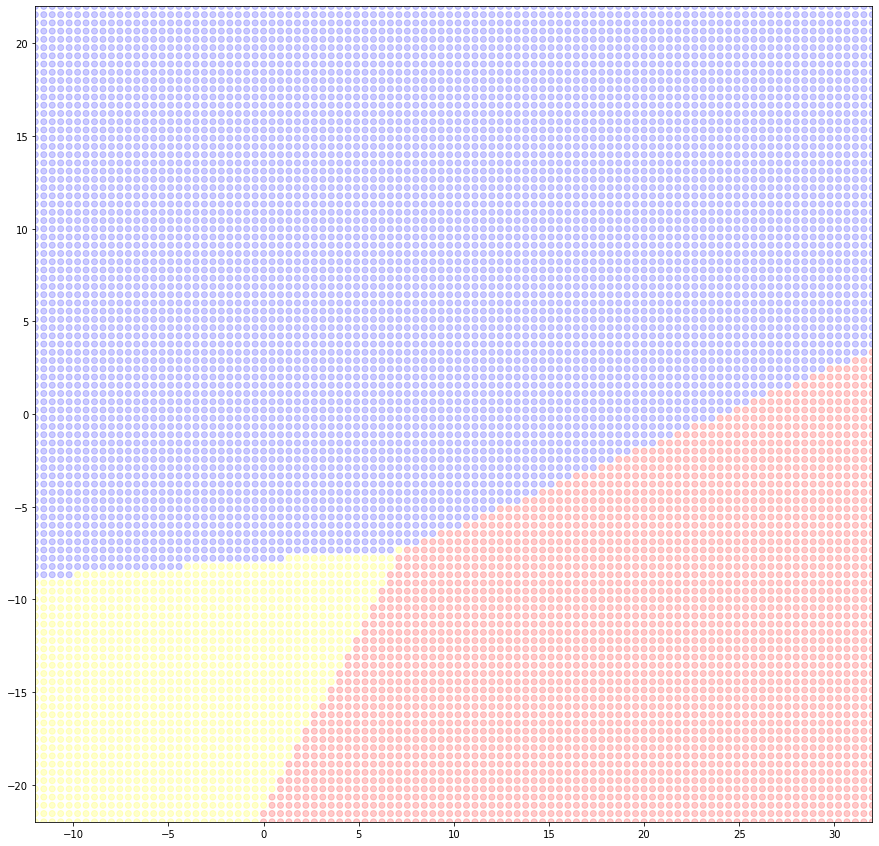

In [49]:
x1_size = -12, 32
x2_size = -22, 22
x1 = [np.min(x_pca[0]), np.max(x_pca[0])]
x2_en = -(clf_en_b + clf_en_w_centered[-1] + np.dot(new_coeffs_en[0], x1)) / new_coeffs_en[1]
x2_de = -(clf_de_b + clf_de_w_centered[-1] + np.dot(new_coeffs_de[0], x1)) / new_coeffs_de[1] 
x2_zh = -(clf_zh_b + clf_zh_w_centered[-1] + np.dot(new_coeffs_zh[0], x1)) / new_coeffs_zh[1] 

boundary_x1_pca = np.linspace(x1_size[0], x1_size[1], 100)
boundary_x2_pca = np.linspace(x2_size[0], x2_size[1], 100)

xx, yy = np.meshgrid(boundary_x1_pca, boundary_x2_pca)

grid = np.vstack([xx.flatten(), yy.flatten()]).T
print(grid.shape)

grid_768 = pca.inverse_transform(grid)
print(grid_768.shape)

out = classifier.classifier(torch.tensor(grid_768, dtype=torch.float))
out = torch.softmax(out, 1).argmax(-1).detach().numpy()
print(out.shape)

ax = plt.axes()
colors = list(map(get_lang_from_id, out))

# contour
ax.scatter(xx.flatten(), yy.flatten(), color=colors, alpha=0.2)

# lines
# ax.plot(x1, x2_en, c='r',linewidth=3.0)
# ax.plot(x1, x2_de, c='yellow',linewidth=3.0)
# ax.plot(x1, x2_zh, c='b',linewidth=3.0)

ax.set_xlim(-12, 32)
ax.set_ylim(-22, 22)

range(0, 10000)
range(46364, 56364)
range(202376, 212376)
range(253577, 263577)
range(305273, 315273)


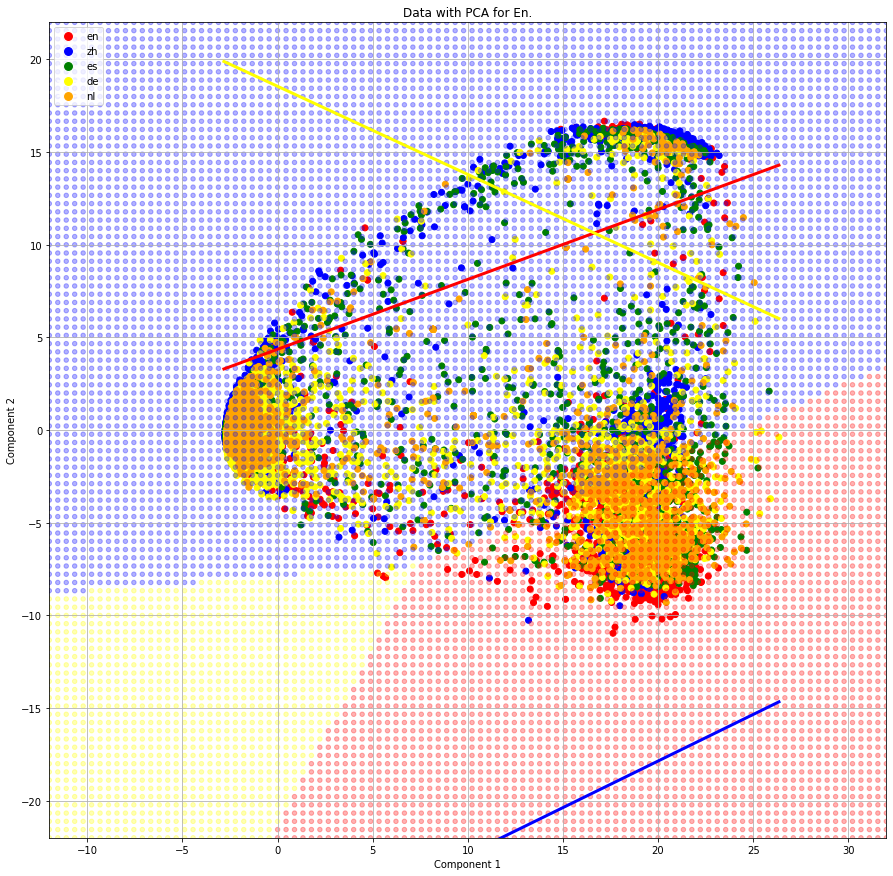

In [47]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,15)
ax = plt.axes()
ax.grid()

# data size from each lang
size = 10000
alpha = 1

# create a scatter plot of the projection
for lang in TRAIN_LANGS:
    range_indx = range(lang_starting_index[lang], lang_starting_index[lang] + size)
    print(range_indx)
    
    #points
    ax.scatter(x_pca.T[range_indx, 0], x_pca.T[range_indx, 1], color=color_lang_arr[list(range_indx)].tolist(), alpha=alpha)

    
#boundary    
x1 = [np.min(x_pca[0]), np.max(x_pca[0])]

# IMPORTANT!!!!! put old intercept 
x2_en = -(clf_en_b + clf_en_w_centered[-1] + np.dot(new_coeffs_en[0], x1)) / new_coeffs_en[1]
x2_de = -(clf_de_b + clf_de_w_centered[-1] + np.dot(new_coeffs_de[0], x1)) / new_coeffs_de[1] 
x2_zh = -(clf_zh_b + clf_zh_w_centered[-1] + np.dot(new_coeffs_zh[0], x1)) / new_coeffs_zh[1] 


ax.plot(x1, x2_en, c='r',linewidth=3.0)
ax.plot(x1, x2_de, c='yellow',linewidth=3.0)
ax.plot(x1, x2_zh, c='b',linewidth=3.0)

ax.scatter(xx.flatten(), yy.flatten(), color=colors, alpha=0.3, s=20)
    
    
#words
#     for i, word in enumerate(words_arr[list(range_indx)].tolist()):
#         ax.text(x_pca.T[range_indx[i], 0], x_pca.T[range_indx[i], 1], x_pca.T[range_indx[i], 2], word)
         

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=c, markersize=10) 
    for l, c in lang_color.items()
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left')
ax.set_xlim(-12, 32)
ax.set_ylim(-22, 22)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title('Data with PCA for En.')
        
plt.show()